<img src="https://i.imgur.com/6U6q5jQ.png"/>

In [ ]:
%reset
# starting fresh

# Geometries

The geodataframe (GDF) is a dataframe (DF) where every row represents an geometry  (point, line, polygon). Python requires you toinstall the **GEOPANDAS** library to work with these structures. Check if you have it using _pip show_.

In the repository for this class you will see a folder named maps, which I have previously downloaded from this [website](https://www.efrainmaps.es/english-version/free-downloads/world/). There are three maps: *countries*, *cities*, and *rivers* of the world.

You may see something like this:

<img src="https://github.com/PythonVersusR/DataStructures_spatial/blob/main/repo_Git.jpg?raw=true">

When you go inside the _maps_ folder you will see this:

<img title="a title" alt="Alt text" src="https://github.com/PythonVersusR/DataStructures_spatial/blob/main/repo_Git_mapFolder.jpg?raw=true">

You see:

1.  A folder with files.
2.  Some *.json* files.
3.  Some *.zip* files. These files are zipped or compressed version of the files in the folder (not the folder with files).

Now, take a look a **World_Countries** folder:

<img src="https://github.com/PythonVersusR/DataStructures_spatial/blob/main/repo_Git_mapFolder_shapes.jpg?raw=true">

There, you see that this **one map** requires **several files**. That is the nature of the shapefile.

Let me get the _raw_ link to each map from GitHub:

In [9]:
linkGit_shape="https://github.com/PythonVersusR/DataStructures_spatial/raw/main/maps/World_Countries/World_Countries.shp"
linkGit_json="https://github.com/PythonVersusR/DataStructures_spatial/raw/main/maps/World_Countries.json"
linkGit_zip="https://github.com/PythonVersusR/DataStructures_spatial/raw/main/maps/World_Countries.zip"

Let's read the file with the help of **geopandas**:

In [10]:
import geopandas as gpd

countriesShape=gpd.read_file(linkGit_shape)
countriesJson=gpd.read_file(linkGit_json)
countriesZip=gpd.read_file(linkGit_zip)

Let's see what we have:

In [11]:
type(countriesShape),type(countriesJson),type(countriesZip)

(geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame,
 geopandas.geodataframe.GeoDataFrame)

Some more info:

In [12]:
countriesShape.info(),countriesJson.info(),countriesZip.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   COUNTRY   252 non-null    object  
 1   geometry  252 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.1+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   COUNTRY   252 non-null    object  
 1   geometry  252 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.1+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   COUNTRY   252 non-null    object  
 1   geometry  252 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.1+ KB


(None, None, None)

Notoce all the files have a column _"geometry"_.

Let me work with the json files for all the maps we have:

In [22]:
citiesLinkGit="https://github.com/PythonVersusR/DataStructures_spatial/raw/main/maps/World_Cities.json"
riversLinkGit="https://github.com/PythonVersusR/DataStructures_spatial/raw/main/maps/World_Hydrography.json"

citiesJson=gpd.read_file(citiesLinkGit)
riversJson=gpd.read_file(riversLinkGit)

We have three maps:

In [23]:
countriesJson.info(),citiesJson.info(),riversJson.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   COUNTRY   252 non-null    object  
 1   geometry  252 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.1+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      610 non-null    object  
 1   COUNTRY   610 non-null    object  
 2   CAPITAL   610 non-null    object  
 3   geometry  610 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 19.2+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      98 non-null     object  
 1   SYSTEM    98 non-null     object  

(None, None, None)

Let's look for more details:

In [25]:
countriesJson.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.87486 12.415..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.73195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.28791 35.55562..."
3,Algeria,"POLYGON ((-2.20944 35.08583, -2.20326 35.03749..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.57249 38..."


In [26]:
citiesJson.head()

,NAME,COUNTRY,CAPITAL,geometry
0,Murmansk,Russia,N,POINT (33.08604 68.96355)
1,Arkhangelsk,Russia,N,POINT (40.64616 64.52067)
2,Saint Petersburg,Russia,N,POINT (30.45333 59.95189)
3,Magadan,Russia,N,POINT (150.78001 59.57100)
4,Perm',Russia,N,POINT (56.23246 58.00024)


In [27]:
riversJson.head()

,NAME,SYSTEM,geometry
0,Aldan,Lena,"LINESTRING (124.00678 56.47258, 123.25956 56.6..."
1,Amazon,Amazon,"MULTILINESTRING ((-61.27730 -3.60706, -60.6846..."
2,Amu Darya,,"LINESTRING (73.98818 37.49952, 73.52595 37.528..."
3,Amur,,"LINESTRING (122.63956 49.99730, 120.47874 49.2..."
4,Angara,,"LINESTRING (105.07841 51.93053, 103.92959 51.7..."


Now you see each file stores different geometries:

In [32]:
riversJson.geom_type.value_counts()

LineString         58
MultiLineString    40
Name: count, dtype: int64

In [33]:
citiesJson.geom_type.value_counts()

Point    610
Name: count, dtype: int64

In [34]:
countriesJson.geom_type.value_counts()

Polygon         137
MultiPolygon    115
Name: count, dtype: int64

Let's see the maps of countries:

<Axes: >

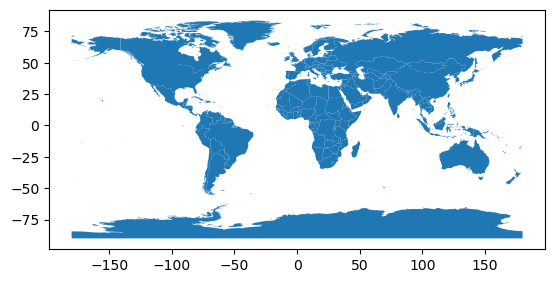

In [36]:
countriesJson.plot() #thickness of lines

<Axes: >

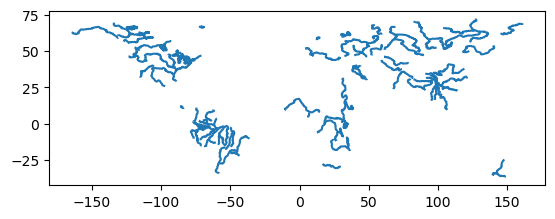

In [37]:
riversJson.plot()

<Axes: >

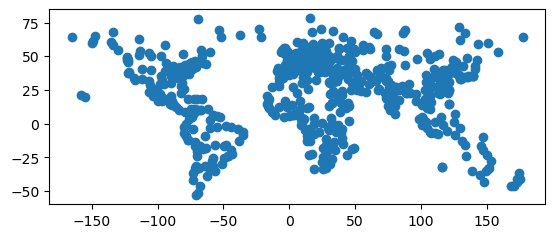

In [38]:
citiesJson.plot()

## Map Projection

The projection (CRS) is a very important property of the maps. They affect several aspects:

* shape
* area
* scale
* direction

If you plan on doing some computations with several maps, you should verify that all have the same projection (**CRS**):

In [40]:
countriesJson.crs==citiesJson.crs==riversJson.crs

True

In [44]:
countriesJson.crs,countriesJson.crs.axis_info, countriesJson.crs.is_projected

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 [Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
  Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)],
 False)

In [45]:
citiesJson.crs,citiesJson.crs.axis_info, citiesJson.crs.is_projected

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 [Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
  Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)],
 False)

In [46]:
riversJson.crs,riversJson.crs.axis_info, riversJson.crs.is_projected

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 [Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
  Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)],
 False)

Our three maps are not projected. Then some math may not work. Let me keep one country:

## Subsetting

You can subset your map by *filtering*:

In [48]:
brazil=countriesJson[countriesJson.COUNTRY=='Brazil']

But you can also subset by *clipping*, as sometimes other data frames may not have the same fields for filtering:

In [54]:
citiesBrazil_clipped = gpd.clip(gdf=citiesJson,
                          mask=brazil)
riversBrazil_clipped = gpd.clip(gdf=riversJson,
                               mask=brazil)

Can we compute the centroid of Brazil?

In [50]:
# this works
brazil.centroid

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_13845/407323332.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brazil.centroid


29    POINT (-53.09009 -10.77302)
dtype: geometry

Then, you can plot the clipped version:

## Reprojecting

A projected CRS will have units in meters or feet (or similar):

For a more accurate option it is better to look for the ones explicitly prepared for a particular locations of the world. You can request a crs per country [here](https://epsg.io/?q=brazil+kind%3APROJCRS):

In [51]:
# recommended for Brazil (meters)
brazil.to_crs(5641).crs.axis_info

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

In [52]:
# this works
brazil.to_crs(5641).centroid

29    POINT (3884486.179 8756856.093)
dtype: geometry

Finally, we can plot what we have:

<Axes: >

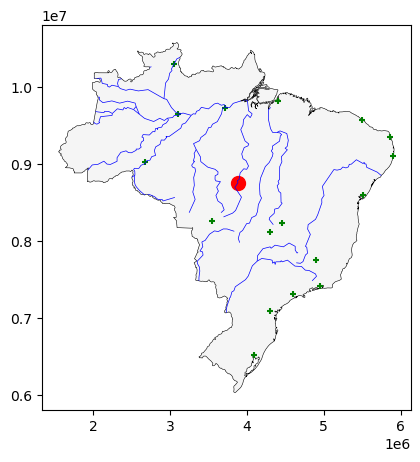

In [74]:
# replotting:

base5641=brazil.to_crs(5641).plot(facecolor="whitesmoke", edgecolor='black', linewidth=0.4,figsize=(5,5))
brazil.to_crs(5641).centroid.plot(color='red',markersize=100,ax=base5641)
citiesBrazil_clipped.to_crs(5641).plot(marker='+', color='green', markersize=15,ax=base5641)
riversBrazil_clipped.to_crs(5641).plot(edgecolor='blue', linewidth=0.5,ax=base5641)